# PCM correlation models 
This demo is meant to show two common ways to use PCM correlation models: 1) to estimate the true correlation between two activity patterns; 2) to test hypotheses about the specific correlation between two sets of activity patterns. 

For more information, see also our [*Brain, Data, and Science*](http://diedrichsenlab.org/BrainDataScience/noisy_correlation) blog on this topic.

## 1. Estimating the true correlation between two activity patterns or conditions
The first part of this jupyter notebook contains the simulations underlying the above-mentioned blog.

In [29]:
# First import necessary libraries
import numpy as np 
import PcmPy as pcm
from PcmPy import sim
import pandas as pd

## 2. Testing for specific correlations between activity patterns across two conditions
In the second part of this notebook, we will simulate data from a hypothetical experiment, in which participants observed 3 hand gestures or executed the same 3 hand gestures. Thus, we have 3 items (i.e., the hand gestures) in each of 2 conditions (i.e., either observe or execute). 

We are interested in the average correlation between the patterns associated with observing and executing action A, observing and executing action B, and observing and executing action C, while accounting for overall differences in the average patterns of observing and executing. To solve this problem, we calculate the likelihood of the data given a range of specific correlations $p(Y|r)$.

Other than setting the correlation values, we need to deal with a few additional parameters. First, the variance of the activity patterns associated with observing or executing different actions. These two hyper-parameters (one per condition but specific for each item) express the strength of the encoding and are directly related to the average inter-item distance in an RSA analysis. Second, we need to consider a pattern component that is caused by the condition itself (observing or executing actions), common to all items. Finally, we need a parameter that determines the noise variance. 

These hyper-parameters are collectively referred to by $\theta$. Here we will compare different models by using the (Type II) maximum likelihood to approximate the model evidence:

$$
p(Y|r) \approx \underset{\theta}{\operatorname{max}}{p(Y|r,\theta)}.
$$

These may seem like a bit of a cheat, but works in this this case quite well. Estimating parameters on the same data that you use to evaluate the model of course leads to an overestimation of the likelihood. However, as the number of hyper-parameters is low and all correlation models have the same number of parameters, this bias will be approximately stable across all models. Since we are interested in the *difference* in log-likelihood across models, this small bias simply disappears. If you want to compare models with different numbers of parameters, a more sophisticated approach, such as group-cross-validation is required. 

In [30]:
# First import necessary libraries
import PcmPy as pcm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import exp, sqrt
import scipy.stats as ss

### 2.1 Data simulation
First, we create our true model: one where the all actions are equally strongly encoded in each conditions, but where the strength of encoding can differ between conditions. For example, we could expect the difference between actions to be smaller during observation than during execution (simply due to overall levels of brain activation). Next, we also model the covariance between items within condition with a condition effect (i.e., by setting `condEffect` to `True`). Finally, we set the ground-truth correlation to be 0.7. 

In [132]:
Mtrue = pcm.CorrelationModel('corr', num_items=3, corr=0.7, cond_effect=True, within_cov=None)
print(f"The true model has {Mtrue.n_param} hyper parameters")

The true model has 4 hyper parameters


These four parameters are concerned with the condition effect and item effect for observation and execution, respectively. Visualizing the components of the second moment matrix (also known as variance-covariance, or simply covariance matrix) helps to understand this:

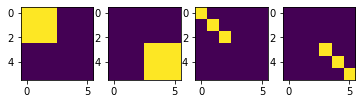

In [33]:
H = Mtrue.n_param
for i in range(H):
    plt.subplot(1,H,i+1)
    plt.imshow(Mtrue.Gc[i,:,:])

The first two components plotted above reflect the condition effect and model the covariance between items within each condition (observation, execution). The second two components reflect the item effect and model the item-specific variance for each item (3 hand gestures) in each condition.

To Simulate a dataset, we need to simulate an experimental design. Let's assume we measure the 6 trial types (3 items x 2 conditions) in 8 imaging runs and submit the beta-values from each run to the model as $\mathbf{Y}$. 

We then generate a dataset where there is a strong overall effect for both observation (exp(0)) and execution (exp(1)). In comparison, the item-specific effects for observation (exp(-1.5)) and execution ((exp(-1))) are pretty weak (this is a rather typical finding).

Note that all hyper parameters are log(variances)—this helps us to keep variances positive and the math easy. 

In [155]:
# Create the design. In this case it's 8 runs, 6 trial types!
cond_vec, part_vec = pcm.sim.make_design(n_cond=6, n_part=8)
#print(cond_vec)
#print(part_vec)

# Starting from the true model above, generate 20 datasets/participants with relatively low signal-to-noise ratio (2:10)
D = pcm.sim.make_dataset(model=Mtrue, theta=[1,2.7,0.4,0.2], cond_vec=cond_vec, part_vec=part_vec, n_sim=20, signal=0.2)

As a quick check, let's plot the predicted second moment matrix of our true model (using the simulation parameters) and the crossvalidated estimate from the first dataset. 

Text(0.5, 1.0, 'dataset')

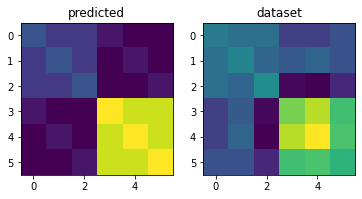

In [125]:
# Get the predicted G-matrix  from the true model
G,_ = Mtrue.predict([1,2.7,0.4,0.2])

# The estimated G-matrix from the first dataset 
trial_type = D[1].obs_descriptors['cond_vec']
G_hat,_ = pcm.est_G_crossval(D[1].measurements, trial_type, part_vec)

# Visualize the second moment (G) matrices
plt.subplot(1,2,1)
plt.imshow(G)
plt.title('predicted')

plt.subplot(1,2,2)
plt.imshow(G_hat)
plt.title('dataset')

### 2.2 Fitting the data 
Now we are fitting these datasets with a range of models, each assuming a correlation value between 0 and 1. The other parameters will still be included, as we did for the true model.

For comparison, we also include a flexible correlation model, which has a additional free parameter that models the correlation.

In [143]:
nsteps = 100 # how many correlation models?  
M = [] # initialize the output list M

# Generate the models equally spaced between 0 and 1 
for r in np.linspace(0, 1, nsteps):
    M.append(pcm.CorrelationModel(f"{r:0.2f}", num_items=3, corr=r, cond_effect=True))
    
# Now make the flexible model 
Mflex = pcm.CorrelationModel("flex", num_items=3, corr=None, cond_effect=True)
M.append(Mflex)

We can now fit the model to the datasets in one go. The resulting dataframe `T` has the log-likelihoods for each model / dataset. The second return argument `theta` contains the parameters for each model fit. 

In [157]:
# In this case, we model the block effect as a mixed effect
# We don't need to include a scale parameter given that we don't have a fixed model 
T, theta = pcm.fit_model_individ(D, M, fixed_effect='block', fit_scale=False, verbose=False)

T.head()

variable  likelihood                                                  \
model           0.00        0.01        0.02        0.03        0.04   
0        -935.267411 -935.060733 -934.856665 -934.655170 -934.456212   
1        -947.828163 -947.635446 -947.445051 -947.256942 -947.071088   
2        -923.461024 -923.220748 -922.983162 -922.748225 -922.515894   
3        -969.095340 -968.884978 -968.677004 -968.471380 -968.268071   
4        -942.833094 -942.620693 -942.410999 -942.203973 -941.999580   

variable                                                              ...  \
model           0.05        0.06        0.07        0.08        0.09  ...   
0        -934.259758 -934.065776 -933.874235 -933.685107 -933.498365  ...   
1        -946.887456 -946.706017 -946.526741 -946.349602 -946.174574  ...   
2        -922.286132 -922.058900 -921.834162 -921.611885 -921.392035  ...   
3        -968.067042 -967.868259 -967.671692 -967.477309 -967.285082  ...   
4        -941.797785 -941.598555 -941.401860 -941.207671 -941.015960  ...   

variable iterations                                               
model          0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.00 flex  
0               6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  5.0  
1               5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  
2               5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  
3               5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  6.0  
4               5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  5.0  

[5 rows x 303 columns]

### 2.3 Interpreting the Fit 
Note that the absolute values of the log-likelihoods don't mean much. Therefore, first, we remove the mean log-likelihood for each correlation model, expressing each log-likelihood as the difference against the mean. Next, we plot the full log-likelihood curves (solid lines) and the maximum likelihood estimate (filled circles) of the correlation for each participant. We can also add the mean log-likelihood curve (dotted line) and the mean of the maximum log-likelihood estimates (vertical blue line) across participants.

Text(0, 0.5, 'log-likelihood')

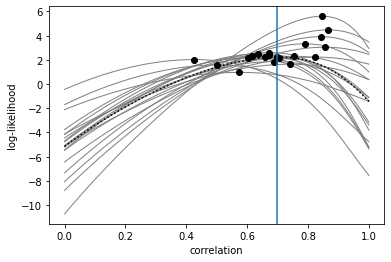

In [145]:
L = T.likelihood.to_numpy()

# express log-likelihoods relative to mean 
L = L - L.mean(axis=1).reshape(-1,1)
maxL = L[:,-1] # Last model is the flexible 
L = L[:,0:-1] # Remove it 

# Get the correlation for each of the models
r = np.empty((nsteps,))
for i in range(nsteps):
    r[i]= M[i].corr

# Get the maximum likelihood estimate of each parameter 
maxr = M[-1].get_correlation(theta[-1])

# Now we make the plot 
plt.plot(r,L.T,color='gray', marker=None, linewidth=1)
plt.plot(maxr,maxL,'k.',markersize=12)
plt.plot(r,L.mean(axis=0),'k:')
plt.axvline(maxr.mean())
plt.xlabel('correlation')
plt.ylabel('log-likelihood')

As we can see, the maximum log-likelihood estimates behave quite well, but the mean of the maximum log-likelihood estimates (vertical line) is not exactly where the maximum of the mean (or group) log-likelihood lies (peak of the mean log-likelihood curve). 

One way to use the log-likelihoods is to do a paired-samples t-test between the log-likelihoods for two correlation values. For example, 0.7 vs 0.3:

In [177]:
print(f"Testing correlation of {r[69]:0.2f} against {r[30]:0.2f}")
t, p = ss.ttest_rel(L[:,69],L[:,30])
print(f'nPaired-samples t-test: t({len(L)-1})={t:1.3f}; p({len(L)-1})={p:1.6f}')

Testing correlation of 0.70 against 0.30
nPaired-samples t-test: t(19)=6.216; p(19)=0.000006


Alternatively, we can transform the log-likelihoods in approximate posterior distributions, and proceed with a Full Bayesian group analysis. 
For more accurate results, you probably want to space your correlation models more tightly.

Text(0, 0.5, 'posterior probability')

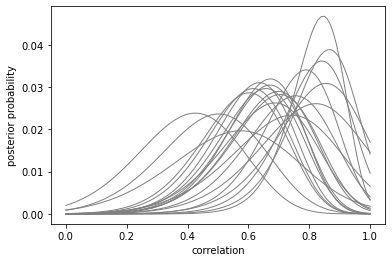

In [178]:
P = exp(L) # Take the exponential of the log-likelihoods
P = P / P.sum(axis=1).reshape(-1,1) # Normalize to 1 over domain 
plt.plot(r,P.T,color='gray', marker=None, linewidth=1)
plt.xlabel('correlation')
plt.ylabel('posterior probability')